In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from tqdm import tqdm

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==========================================
# 1. DEFINE MODEL ARCHITECTURE (Must match training exactly)
# ==========================================
class MultimodalPropertyModel(nn.Module):
    def __init__(self, num_tabular_features=35, image_embedding_dim=256, tabular_embedding_dim=128):
        super(MultimodalPropertyModel, self).__init__()
        
        # Image Branch (ResNet18)
        resnet = models.resnet18(pretrained=False)
        self.image_feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        
        # Note: We removed BatchNorm in the optimized CPU version
        self.image_fc = nn.Sequential(
            nn.Linear(512, image_embedding_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Tabular Branch
        self.tabular_branch = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, tabular_embedding_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Fusion
        fusion_input_dim = image_embedding_dim + tabular_embedding_dim
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
    
    def forward(self, images, tabular):
        img_features = self.image_feature_extractor(images)
        img_features = img_features.view(img_features.size(0), -1)
        img_embedding = self.image_fc(img_features)
        tab_embedding = self.tabular_branch(tabular)
        fused = torch.cat([img_embedding, tab_embedding], dim=1)
        output = self.fusion_layer(fused)
        return output

# ==========================================
# 2. LOAD BEST SAVED MODEL
# ==========================================
print("\n📂 Loading best model weights...")
model = MultimodalPropertyModel(num_tabular_features=35)

# Load weights (map_location ensures it loads on CPU)
model.load_state_dict(torch.load('../outputs/models/best_multimodal_model.pth', map_location=device))
model = model.to(device)
model.eval()

print("✅ Model loaded successfully!")


Using device: cpu

📂 Loading best model weights...


d:\satellite-property-valuation\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\satellite-property-valuation\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model loaded successfully!


In [2]:
# Load Test Data
print("Loading test data...")
X_test = pd.read_csv('../data/processed/X_test_scaled.csv')
test_df = pd.read_excel('../data/raw/test.xlsx')

# Define Transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class PropertyTestDataset(Dataset):
    def __init__(self, df, tabular_features, image_dir, transform=None):
        self.df = df
        self.tabular_features = tabular_features
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        pid = self.df.iloc[idx]['id']
        img_path = os.path.join(self.image_dir, f"{pid}.jpg")
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (400, 400), (0, 0, 0)) # Placeholder
            
        if self.transform:
            image = self.transform(image)
            
        tabular = torch.FloatTensor(self.tabular_features.iloc[idx].values)
        return image, tabular, pid

# Create DataLoader
test_dataset = PropertyTestDataset(test_df, X_test, '../data/images/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Generate Predictions
print("🚀 Generating predictions...")
predictions = []
ids = []

with torch.no_grad():
    for images, tabular, pids in tqdm(test_loader):
        images, tabular = images.to(device), tabular.to(device)
        outputs = model(images, tabular)
        
        predictions.extend(outputs.cpu().numpy().flatten())
        ids.extend(pids.tolist())

# Create Submission DataFrame
submission_df = pd.DataFrame({
    'id': ids,
    'price': predictions
})

# Save
os.makedirs('../outputs/predictions', exist_ok=True)
submission_path = '../outputs/predictions/multimodal_submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"\n✅ Predictions saved to: {submission_path}")
print(submission_df.head())


Loading test data...
🚀 Generating predictions...


100%|██████████| 169/169 [03:09<00:00,  1.12s/it]


✅ Predictions saved to: ../outputs/predictions/multimodal_submission.csv
           id         price
0  2591820310  4.671858e+05
1  7974200820  9.469637e+05
2  7701450110  1.312134e+06
3  9522300010  2.106876e+06
4  9510861140  6.078450e+05


In [3]:
# ==========================================
# GRAD-CAM IMPLEMENTATION
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_heatmap(self, image, tabular):
        """Generate heatmap for a single image"""
        self.model.zero_grad()
        
        # Forward pass
        output = self.model(image.unsqueeze(0), tabular.unsqueeze(0))
        
        # Backward pass
        output.backward()
        
        # Calculate weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Weighted combination of activation maps
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        
        # ReLU and normalize
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.cpu().numpy()

# Initialize Grad-CAM
# Target the last convolutional layer in ResNet18
target_layer = model.image_feature_extractor[7][1].conv2  # Last conv layer in ResNet18
gradcam = GradCAM(model, target_layer)

print("✅ Grad-CAM initialized!")


✅ Grad-CAM initialized!


📊 Selected Properties for Grad-CAM Visualization:
🏰 High Value Properties: [1225069038, 7558700030, 7738500731]
🏠 Low Value Properties: [1951600240, 421049114, 7686202580]


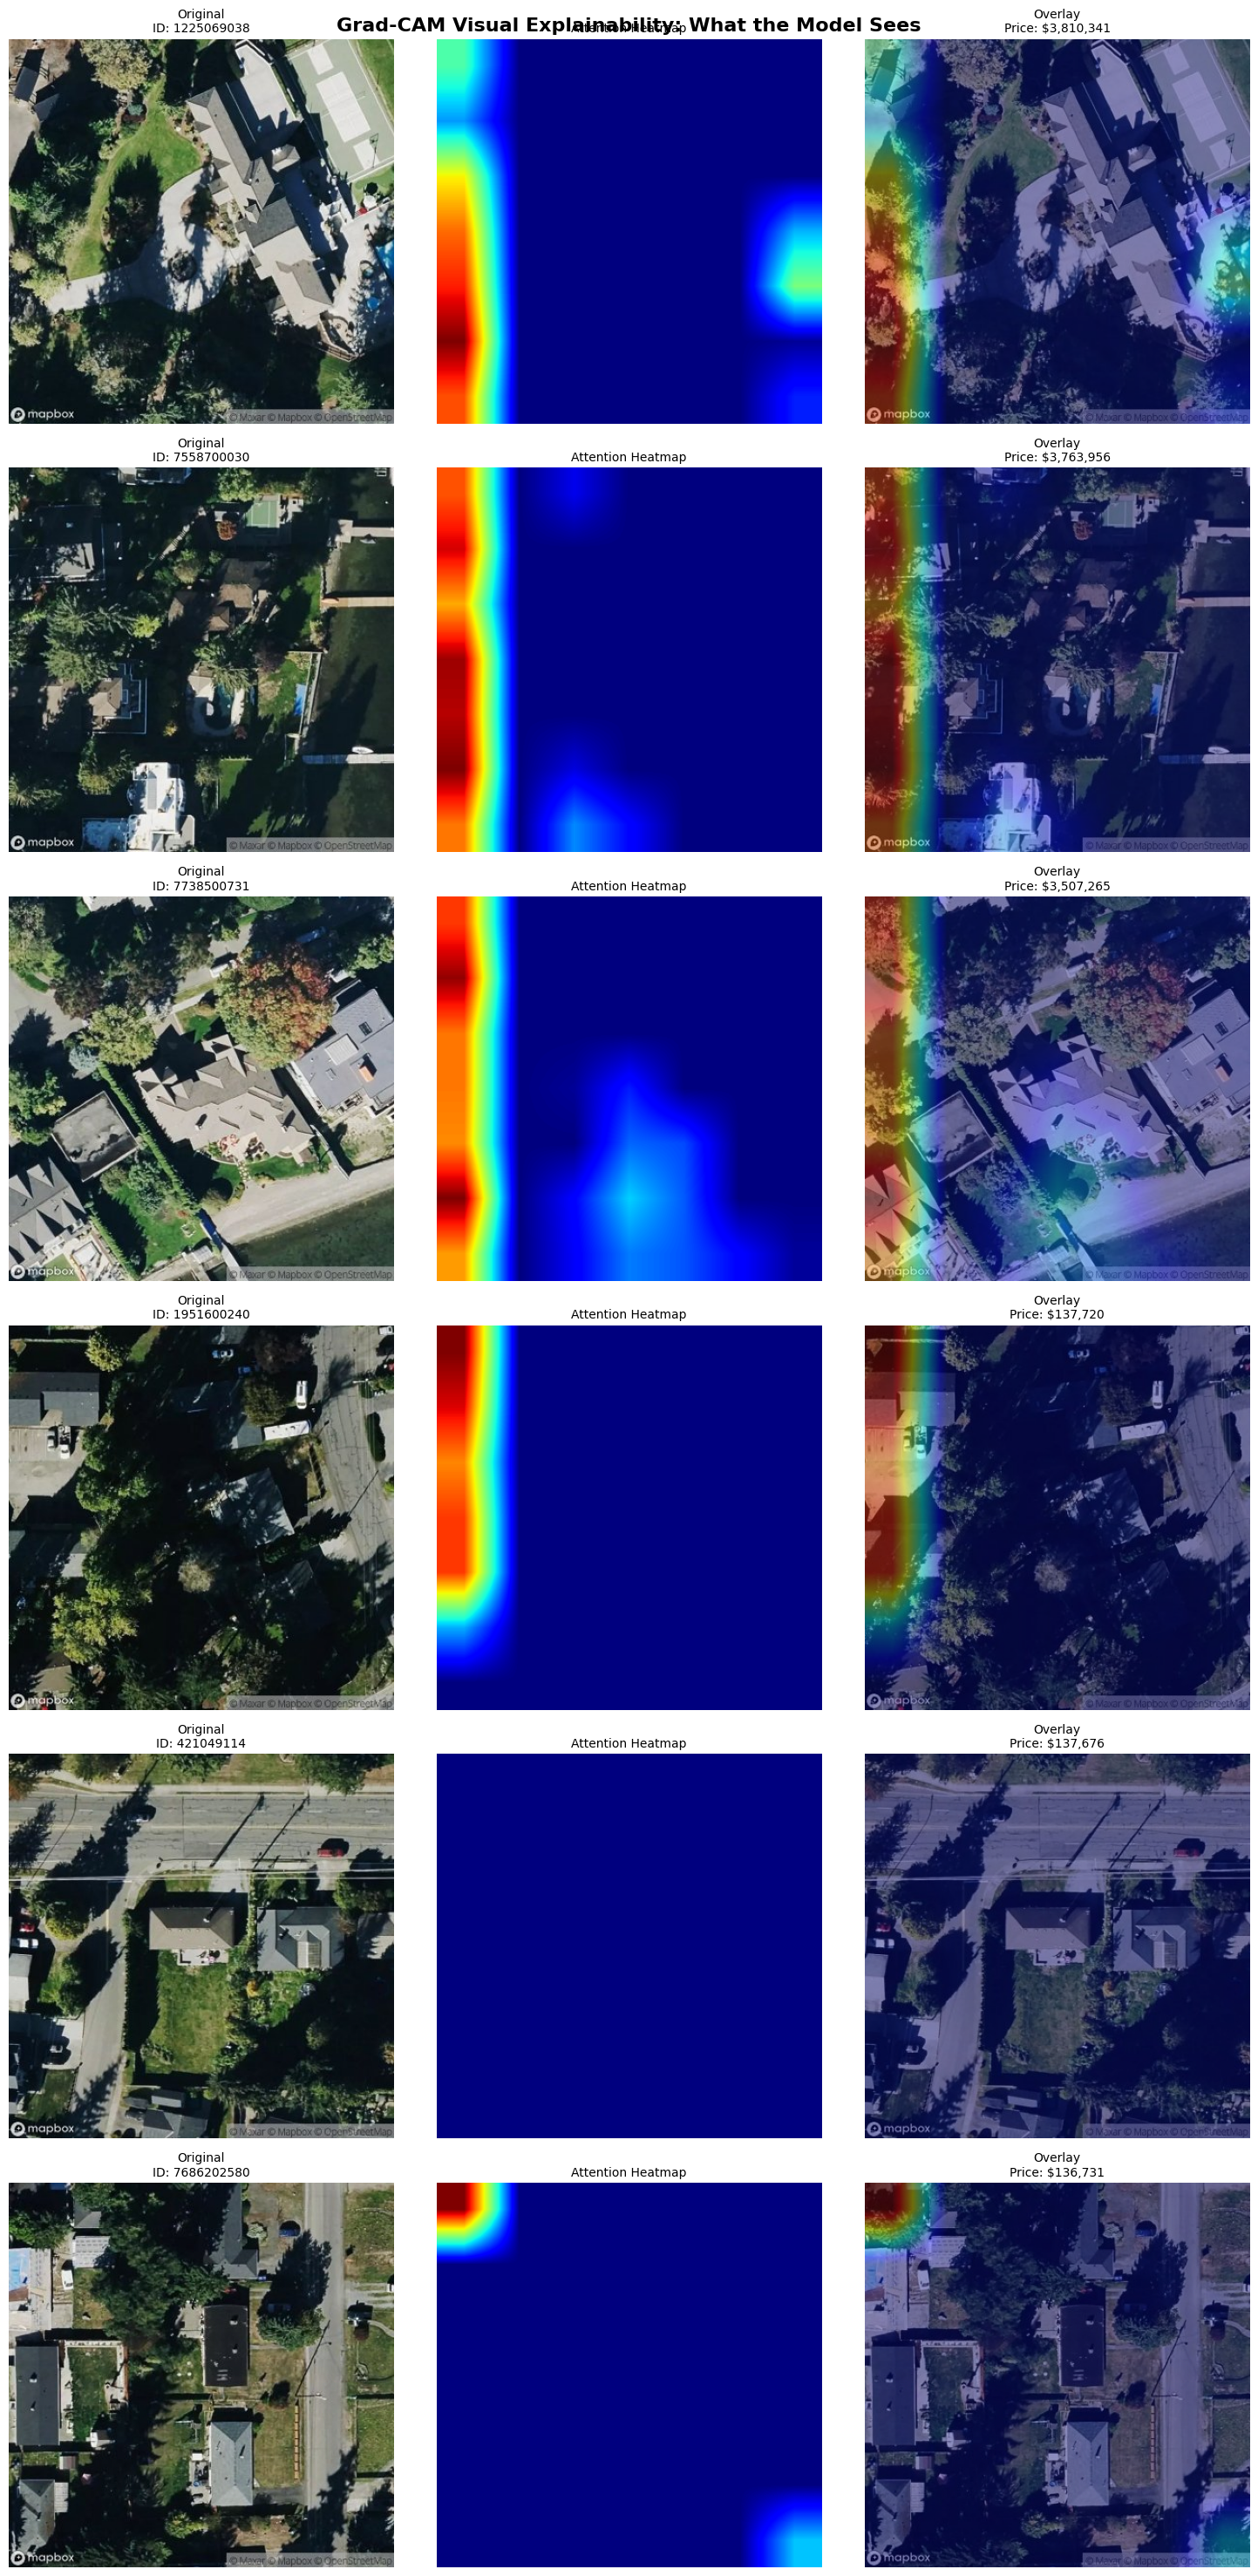


✅ Grad-CAM visualizations saved to: ../outputs/gradcam_visualization.png


In [4]:
def visualize_gradcam(image_path, tabular_features, predicted_price, model, gradcam):
    """Create Grad-CAM visualization overlay"""
    
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    
    # Transform for model
    img_transformed = test_transform(img).to(device)
    tabular_tensor = torch.FloatTensor(tabular_features.values).to(device)
    
    # Generate heatmap
    model.eval()
    heatmap = gradcam.generate_heatmap(img_transformed, tabular_tensor)
    
    # Resize heatmap to original image size
    heatmap_resized = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    
    # Apply colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Overlay
    overlay = cv2.addWeighted(img_array, 0.6, heatmap_colored, 0.4, 0)
    
    return img_array, overlay, heatmap_resized

# Select interesting properties to visualize
# Get top 5 highest predictions and bottom 5 lowest predictions
submission_sorted = submission_df.sort_values('price', ascending=False)
high_value_ids = submission_sorted.head(5)['id'].tolist()
low_value_ids = submission_sorted.tail(5)['id'].tolist()

print("📊 Selected Properties for Grad-CAM Visualization:")
print(f"🏰 High Value Properties: {high_value_ids[:3]}")
print(f"🏠 Low Value Properties: {low_value_ids[:3]}")

# Visualize 3 high-value and 3 low-value properties
sample_ids = high_value_ids[:3] + low_value_ids[:3]

fig, axes = plt.subplots(6, 3, figsize=(15, 30))
fig.suptitle('Grad-CAM Visual Explainability: What the Model Sees', fontsize=16, fontweight='bold')

for idx, property_id in enumerate(sample_ids):
    # Get property data
    prop_idx = test_df[test_df['id'] == property_id].index[0]
    tabular_features = X_test.iloc[prop_idx]
    predicted_price = submission_df[submission_df['id'] == property_id]['price'].values[0]
    
    # Image path
    img_path = f'../data/images/test/{property_id}.jpg'
    
    # Check if image exists
    if not os.path.exists(img_path):
        print(f"⚠️ Image not found for {property_id}, skipping...")
        continue
    
    # Generate visualization
    original, overlay, heatmap = visualize_gradcam(
        img_path, tabular_features, predicted_price, model, gradcam
    )
    
    # Plot
    axes[idx, 0].imshow(original)
    axes[idx, 0].set_title(f'Original\nID: {property_id}', fontsize=10)
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(heatmap, cmap='jet')
    axes[idx, 1].set_title('Attention Heatmap', fontsize=10)
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(overlay)
    axes[idx, 2].set_title(f'Overlay\nPrice: ${predicted_price:,.0f}', fontsize=10)
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.savefig('../outputs/gradcam_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Grad-CAM visualizations saved to: ../outputs/gradcam_visualization.png")
